In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [2]:
BTC = "BTC-USD"
ETH = "ETH-USD"
SPDR = "SPY"

In [3]:
stocks = yf.Tickers(
    [BTC, ETH, SPDR]
)

hist = stocks.history(period="5Y").Close
hist_close = hist.ffill()
hist_close = hist_close.loc[hist.index.day_of_week == 0]

[*********************100%%**********************]  3 of 3 completed


/opt/homebrew/Caskroom/miniconda/base/envs/quant/lib/python3.11/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/homebrew/Caskroom/miniconda/base/envs/quant/lib/python3.11/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/homebrew/Caskroom/miniconda/base/envs/quant/lib/python3.11/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [4]:
next_price = hist_close.shift(-1)
returns = pd.DataFrame(
    ((next_price.values - hist_close.values) / hist_close.values) * 100,
    columns=[BTC, ETH, SPDR],
)
returns['Date'] = hist_close.index
returns = returns.dropna()

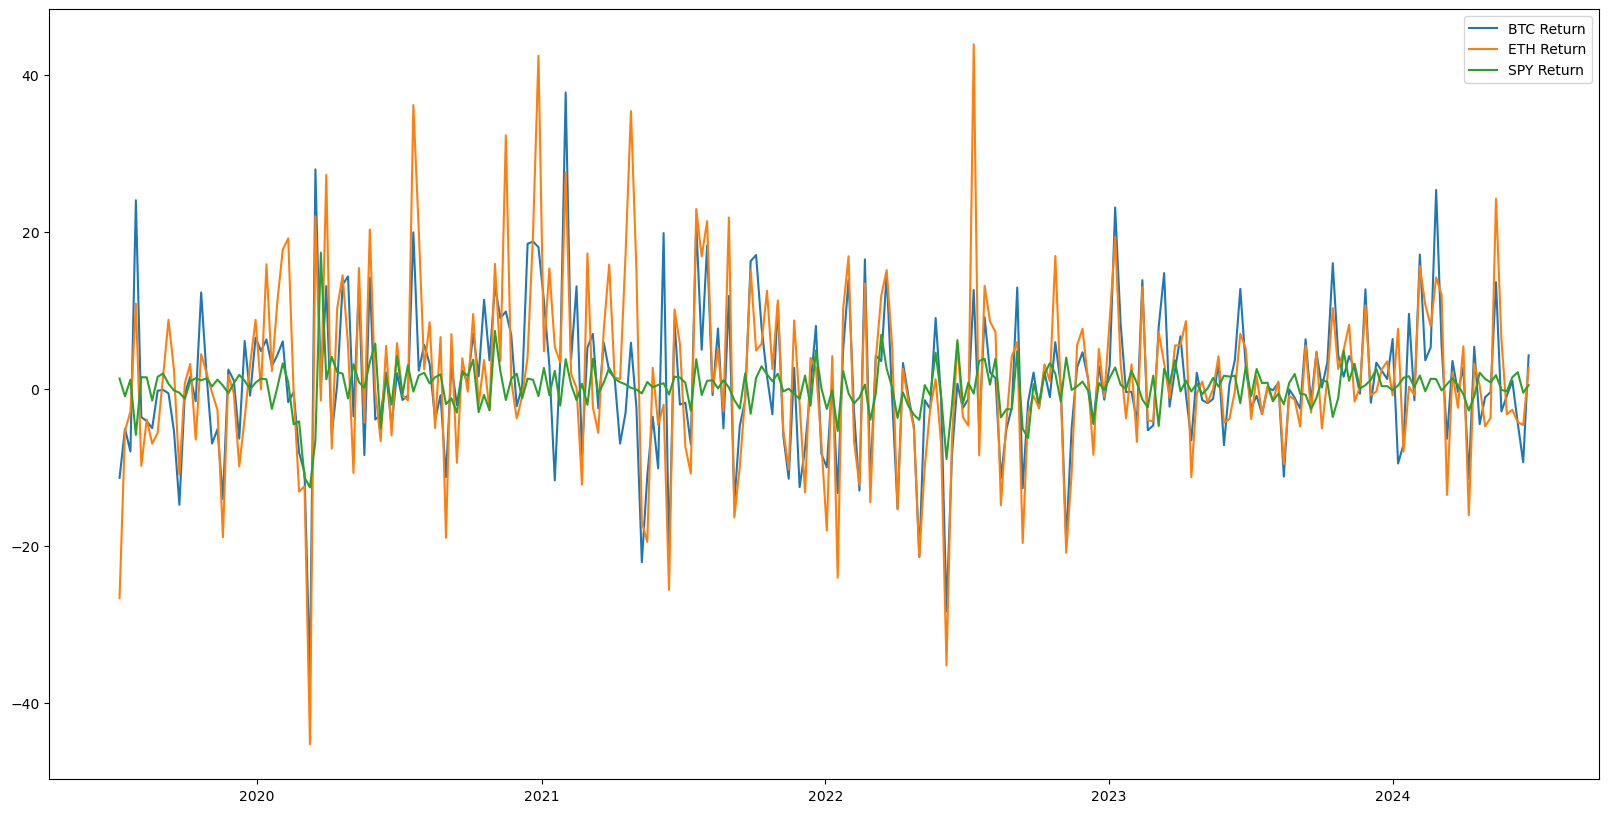

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))
plt.plot(returns['Date'], returns[BTC], label='BTC Return')
plt.plot(returns['Date'], returns[ETH], label='ETH Return')
plt.plot(returns['Date'], returns[SPDR], label='SPY Return')
plt.legend()
plt.show()

In [6]:
from arch.unitroot import ADF

btc_adf = ADF(returns[BTC].values, trend="n", method="bic")
eth_adf = ADF(returns[ETH].values, trend="n", method="bic")
spdr_adf = ADF(returns[SPDR].values, trend="n", method="bic")

pd.DataFrame(
    {
        "BTC Price": (btc_adf.stat, btc_adf.critical_values["5%"]),
        "ETH": (eth_adf.stat, eth_adf.critical_values["5%"]),
        "SPDR": (
            spdr_adf.stat,
            spdr_adf.critical_values["5%"],
        ),
    },
    index=["ADF Test Statistic", "5% Critical Value"],
)

,BTC Price,ETH,SPDR
ADF Test Statistic,-15.678759,-14.831409,-14.932108
5% Critical Value,-1.942085,-1.942085,-1.942085


In [7]:
var = sm.tsa.VAR(returns.drop(columns=['Date']))
x = var.select_order(maxlags=12, trend='c')
x.summary()

,AIC,BIC,FPE,HQIC
0,10.24,10.28*,2.789e+04,10.25*
1,10.21*,10.38,2.704e+04*,10.27
2,10.25,10.55,2.836e+04,10.37
3,10.26,10.69,2.868e+04,10.43
4,10.31,10.86,2.998e+04,10.53
5,10.30,10.98,2.963e+04,10.57
6,10.33,11.14,3.079e+04,10.66
7,10.36,11.30,3.170e+04,10.74
8,10.36,11.43,3.178e+04,10.79
9,10.40,11.59,3.304e+04,10.88


In [8]:
var_mod = var.fit(
    maxlags=None,
    # when maxlags=None criterion to use for VAR order selection is
    # ic{'aic', 'fpe', 'hqic', 'bic', None}
    ic=None,  # ic=None => automatic lag selection
    method="ols",
    trend="c",
    verbose=True,
)
var_mod.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 07, Jul, 2024
Time:                     14:40:17
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    10.3604
Nobs:                     259.000    HQIC:                   10.2618
Log likelihood:          -2410.84    FPE:                    26784.7
AIC:                      10.1956    Det(Omega_mle):         25581.1
--------------------------------------------------------------------
Results for equation BTC-USD
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              1.045023         0.578366            1.807           0.071
L1.BTC-USD         0.033447         0.101935            0.328           0.743
L1.ETH-USD        -0.047356         0.082124           -0.577         

In [9]:
print(var_mod.k_ar)

1


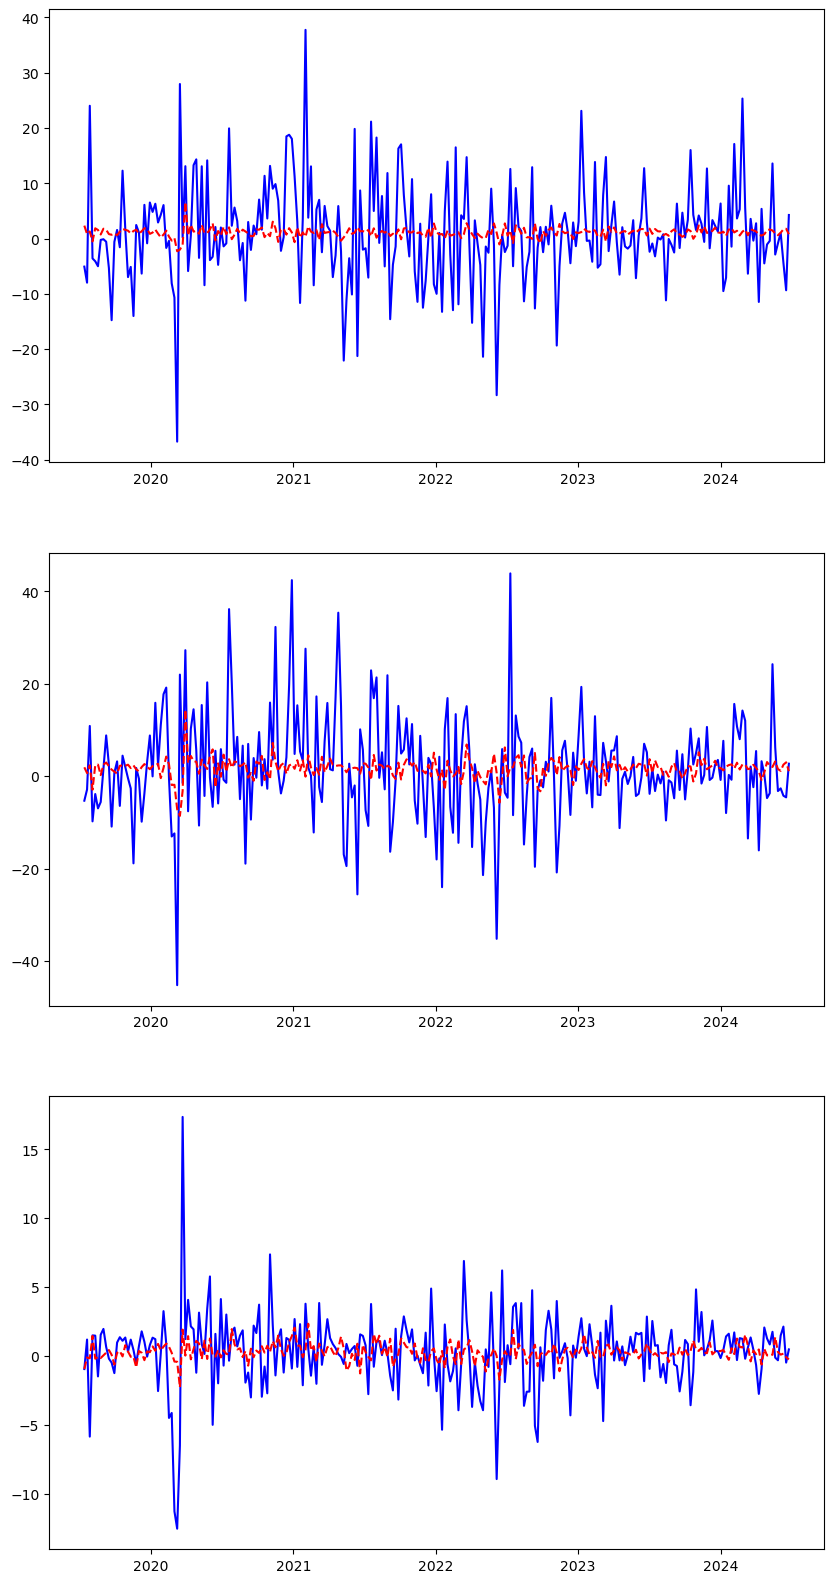

In [10]:
in_sample = var.predict(var_mod.params)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 20))
ax1.plot(returns['Date'][1:], returns[BTC][1:], label='BTC Actuals', c='b')
ax1.plot(returns['Date'][1:], in_sample[:, 0], label='BTC Predict', c='r', linestyle="--")

ax2.plot(returns['Date'][1:], returns[ETH][1:], label='ETH Actuals', c='b')
ax2.plot(returns['Date'][1:], in_sample[:, 1], label='ETH Predict', c='r', linestyle="--")

ax3.plot(returns['Date'][1:], returns[SPDR][1:], label='SPDR Actuals', c='b')
ax3.plot(returns['Date'][1:], in_sample[:, 2], label='SPDR Predict', c='r', linestyle="--")

In [57]:
var_mod.forecast(y=returns.drop(columns=['Date']).values[1:], steps=1)

array([[1.21183274, 1.8183039 , 0.44643225]])

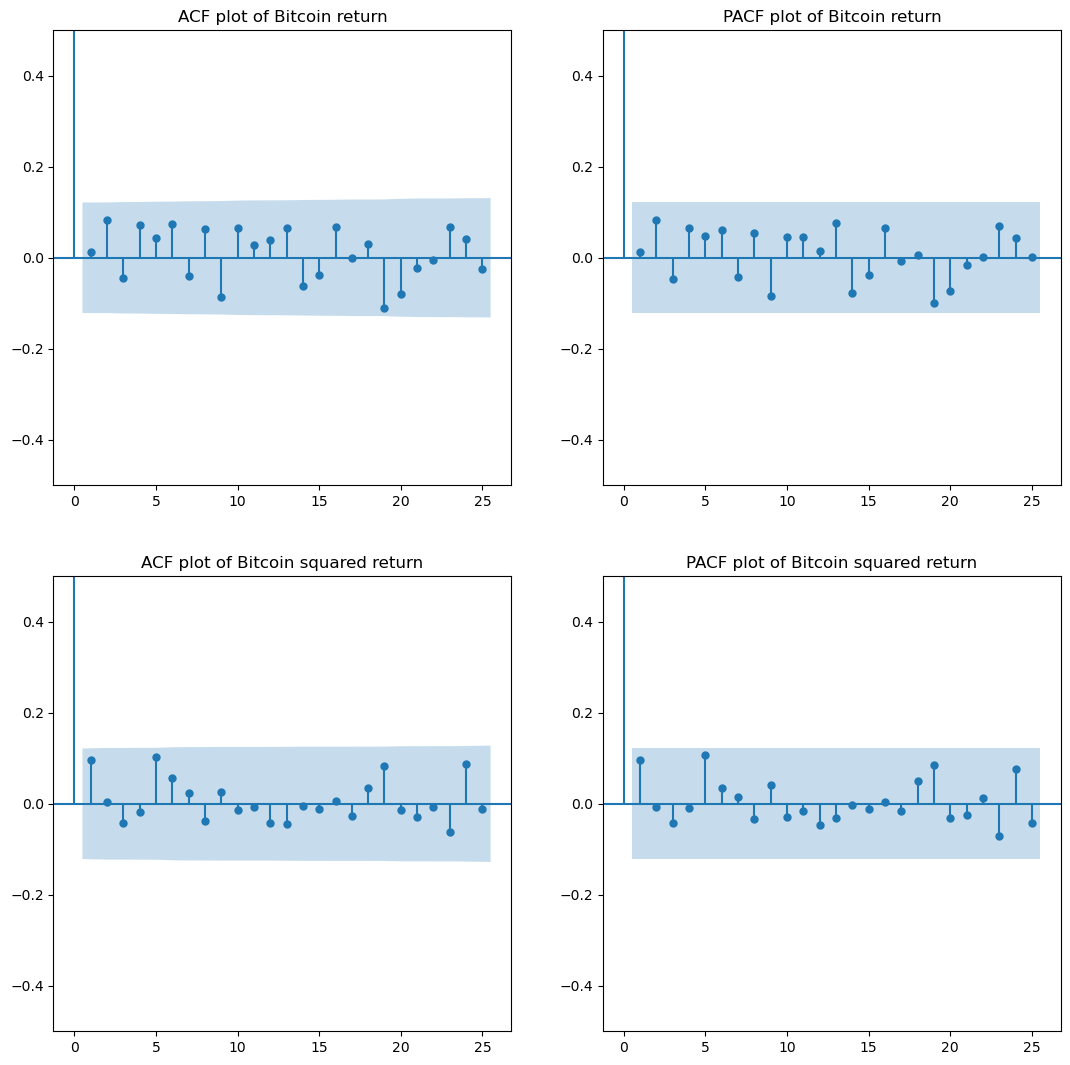

In [16]:
from arch import arch_model
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox

# ACF and PACF Plots for Google Stock Returns and Squared Returns
fig, ax = plt.subplots(2, 2, figsize=(13, 13))

sm.graphics.tsa.plot_acf(returns[BTC].values, ax=ax[0, 0])
ax[0, 0].set(title="ACF plot of Bitcoin return")
ax[0, 0].set_ylim([-0.5, 0.5])

sm.graphics.tsa.plot_pacf(returns[BTC].values, ax=ax[0, 1])
ax[0, 1].set(title="PACF plot of Bitcoin return")
ax[0, 1].set_ylim([-0.5, 0.5])

sm.graphics.tsa.plot_acf(returns[BTC].values ** 2, ax=ax[1, 0])
ax[1, 0].set(title="ACF plot of Bitcoin squared return")
ax[1, 0].set_ylim([-0.5, 0.5])

sm.graphics.tsa.plot_pacf(returns[BTC].values ** 2, ax=ax[1, 1])
ax[1, 1].set(title="PACF plot of Bitcoin squared return")
ax[1, 1].set_ylim([-0.5, 0.5])
plt.show()

In [23]:
# GARCH(1,1) Model with Normal White Noise
garch11_spec = arch_model(
    returns[BTC].values,
    vol="GARCH",
    p=1,
    q=1,
    mean="AR",
    dist="StudentsT",
    # rescale=True,
)
garch11_fit = garch11_spec.fit()
garch11_fit.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 8770.6607349888
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1391.8869366078752
Iteration:      3,   Func. Count:     25,   Neg. LLF: 940.9740681840435
Iteration:      4,   Func. Count:     32,   Neg. LLF: 931.8940277902274
Iteration:      5,   Func. Count:     38,   Neg. LLF: 947.6890849506761
Iteration:      6,   Func. Count:     45,   Neg. LLF: 931.3982251195937
Iteration:      7,   Func. Count:     51,   Neg. LLF: 931.4071662413959
Iteration:      8,   Func. Count:     58,   Neg. LLF: 931.3150055221689
Iteration:      9,   Func. Count:     64,   Neg. LLF: 931.2950308804983
Iteration:     10,   Func. Count:     70,   Neg. LLF: 931.2900062197853
Iteration:     11,   Func. Count:     76,   Neg. LLF: 931.2887990254249
Iteration:     12,   Func. Count:     82,   Neg. LLF: 931.2886432710435
Iteration:     13,   Func. Count:     88,   Neg. LLF: 931.2886203614955
Iteration:     14,   Func. Count:     94,   Neg. LLF: 931.2886188

<class 'statsmodels.iolib.summary.Summary'>
"""
                              AR - GARCH Model Results                              
====================================================================================
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -931.289
Distribution:      Standardized Student's t   AIC:                           1872.58
Method:                  Maximum Likelihood   BIC:                           1890.38
                                              No. Observations:                  260
Date:                      Sun, Jul 07 2024   Df Residuals:                      259
Time:                              15:07:43   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const          0.7205      0.475      1.516      0.130 [ -0.211,  1.652]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.6708      1.419      0.473      0.636      [ -2.111,  3.453]
alpha[1]       0.0345  2.121e-02      1.625      0.104 [-7.103e-03,7.605e-02]
beta[1]        0.9612  2.004e-02     47.963      0.000      [  0.922,  1.000]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.7055      0.911      4.066  4.787e-05 [  1.919,  5.492]
========================================================================

Covariance estimator: robust
"""

In [24]:
# Diagnostic tests for GARCH(1,1) Model with Normal White Noise
print("GARCH(1,1) Model with Normal White Noise\n")

# Ljung-Box test and the Box-Pierce test
print("Ljung-Box and Box-Pierce tests on stanrdized residuals")
print(acorr_ljungbox(garch11_fit.std_resid, boxpierce=True))

print("\nLjung-Box and Box-Pierce tests on stanrdized squared residuals")
print(acorr_ljungbox(garch11_fit.std_resid**2, boxpierce=True))

# ARCH LM test for conditional heteroskedasticity
print("\nARCH LM test for conditional heteroskedasticity")
print(garch11_fit.arch_lm_test(standardized=True))

GARCH(1,1) Model with Normal White Noise

Ljung-Box and Box-Pierce tests on stanrdized residuals
     lb_stat  lb_pvalue   bp_stat  bp_pvalue
1   0.336060   0.562112  0.332212   0.564359
2   1.879991   0.390630  1.852571   0.396022
3   1.944113   0.584087  1.915470   0.590135
4   2.659884   0.616252  2.614849   0.624195
5   3.247581   0.661876  3.186845   0.671205
6   3.989321   0.678122  3.905936   0.689404
7   4.377074   0.735465  4.280369   0.746977
8   5.121475   0.744517  4.996358   0.757965
9   7.797715   0.554653  7.560237   0.578997
10  8.793249   0.551831  8.510173   0.579132

Ljung-Box and Box-Pierce tests on stanrdized squared residuals
     lb_stat  lb_pvalue   bp_stat  bp_pvalue
1   1.927243   0.165060  1.905175   0.167500
2   2.060727   0.356877  2.036621   0.361205
3   2.247627   0.522628  2.219954   0.528029
4   2.815828   0.589104  2.775144   0.596131
5   3.319625   0.650838  3.265480   0.659131
6   3.553442   0.736846  3.492157   0.745013
7   3.553442   0.829533  3.49

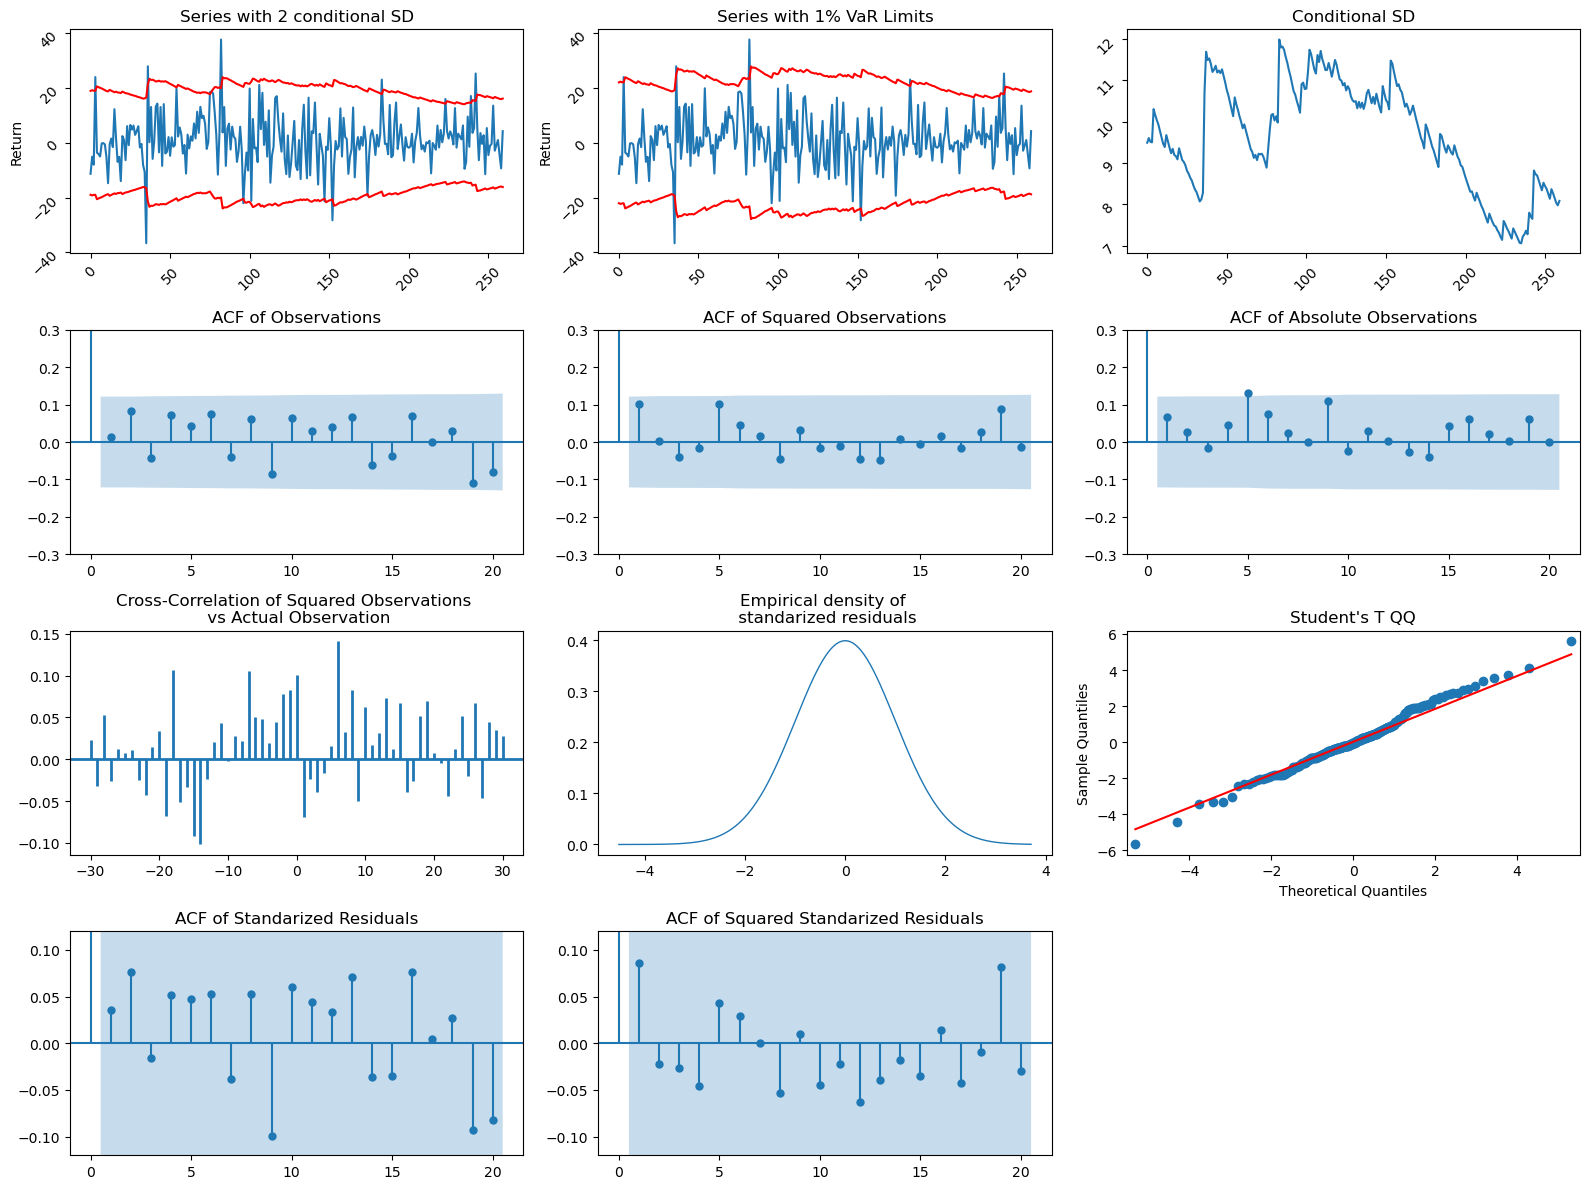

In [52]:
# Model Diagnostic Plots for the GARCH(1,1) Model with Normal White Noise
fig, ax = plt.subplots(4, 3, figsize=(16, 12))

# Figure Row 1 Column 1
ax[0, 0].plot(returns[BTC].values)
ax[0, 0].plot(2.0 * garch11_fit.conditional_volatility, c="r")
ax[0, 0].plot(-2.0 * garch11_fit.conditional_volatility, c="r")
ax[0, 0].tick_params(labelrotation=45)
ax[0, 0].set_title("Series with 2 conditional SD")
ax[0, 0].set_ylabel("Return")

# Figure Row 1 Column 2
VaR_1 = stats.norm.ppf(0.99)
ax[0, 1].plot(returns[BTC].values)
ax[0, 1].plot(VaR_1 * garch11_fit.conditional_volatility, c="r")
ax[0, 1].plot(-VaR_1 * garch11_fit.conditional_volatility, c="r")
ax[0, 1].tick_params(labelrotation=45)
ax[0, 1].set_title("Series with 1% VaR Limits")
ax[0, 1].set_ylabel("Return")

# Figure Row 1 Column 3
ax[0, 2].plot(garch11_fit.conditional_volatility)
ax[0, 2].set_title("Conditional SD")
ax[0, 2].tick_params(labelrotation=45)

# Figure Row 2 Column 1
sm.graphics.tsa.plot_acf(garch11_fit.resid, lags=20, ax=ax[1, 0])
ax[1, 0].set_title("ACF of Observations")
ax[1, 0].set_ylim([-0.3, 0.3])

# Figure Row 2 Column 2
sm.graphics.tsa.plot_acf(garch11_fit.resid**2, lags=20, ax=ax[1, 1])
ax[1, 1].set_title("ACF of Squared Observations")
ax[1, 1].set_ylim([-0.3, 0.3])

# Figure Row 2 Column 3
sm.graphics.tsa.plot_acf(np.abs(garch11_fit.resid), lags=20, ax=ax[1, 2])
ax[1, 2].set_title("ACF of Absolute Observations")
ax[1, 2].set_ylim([-0.3, 0.3])

# Figure Row 3 Column 1
ax[2, 0].xcorr(
    garch11_fit.resid**2,
    garch11_fit.resid,
    usevlines=True,
    maxlags=30,
    normed=True,
    lw=2,
)
ax[2, 0].set_title("Cross-Correlation of Squared Observations \n vs Actual Observation")

# Figure Row 3 Column 2
standaraized_residuals = garch11_fit.std_resid
min_val = np.min(standaraized_residuals)
max_val = np.max(standaraized_residuals)
empirical_density = np.linspace(min_val, max_val, len(standaraized_residuals))
ax[2, 1].plot(empirical_density, stats.norm.pdf(empirical_density), lw=1)
ax[2, 1].set_title("Empirical density of \n standarized residuals")

# Figure Row 3 Column 3
sm.qqplot(garch11_fit.resid, stats.t, fit=True, line="q", ax=ax[2, 2])
ax[2, 2].set_title("Student's T QQ")

# Figure Row 4 Column 1
sm.graphics.tsa.plot_acf(garch11_fit.std_resid, lags=20, ax=ax[3, 0])
ax[3, 0].set_title("ACF of Standarized Residuals")
ax[3, 0].set_ylim([-0.12, 0.12])

# Figure Row 4 Column 2
sm.graphics.tsa.plot_acf((garch11_fit.std_resid) ** 2, lags=20, ax=ax[3, 1])
ax[3, 1].set_title("ACF of Squared Standarized Residuals")
ax[3, 1].set_ylim([-0.12, 0.12])

ax[3, 2].axis("off")
fig.tight_layout()
plt.show()

/var/folders/p0/pbqvxybs0lg7lb7xzx1n1m440000gn/T/ipykernel_8002/3011852363.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


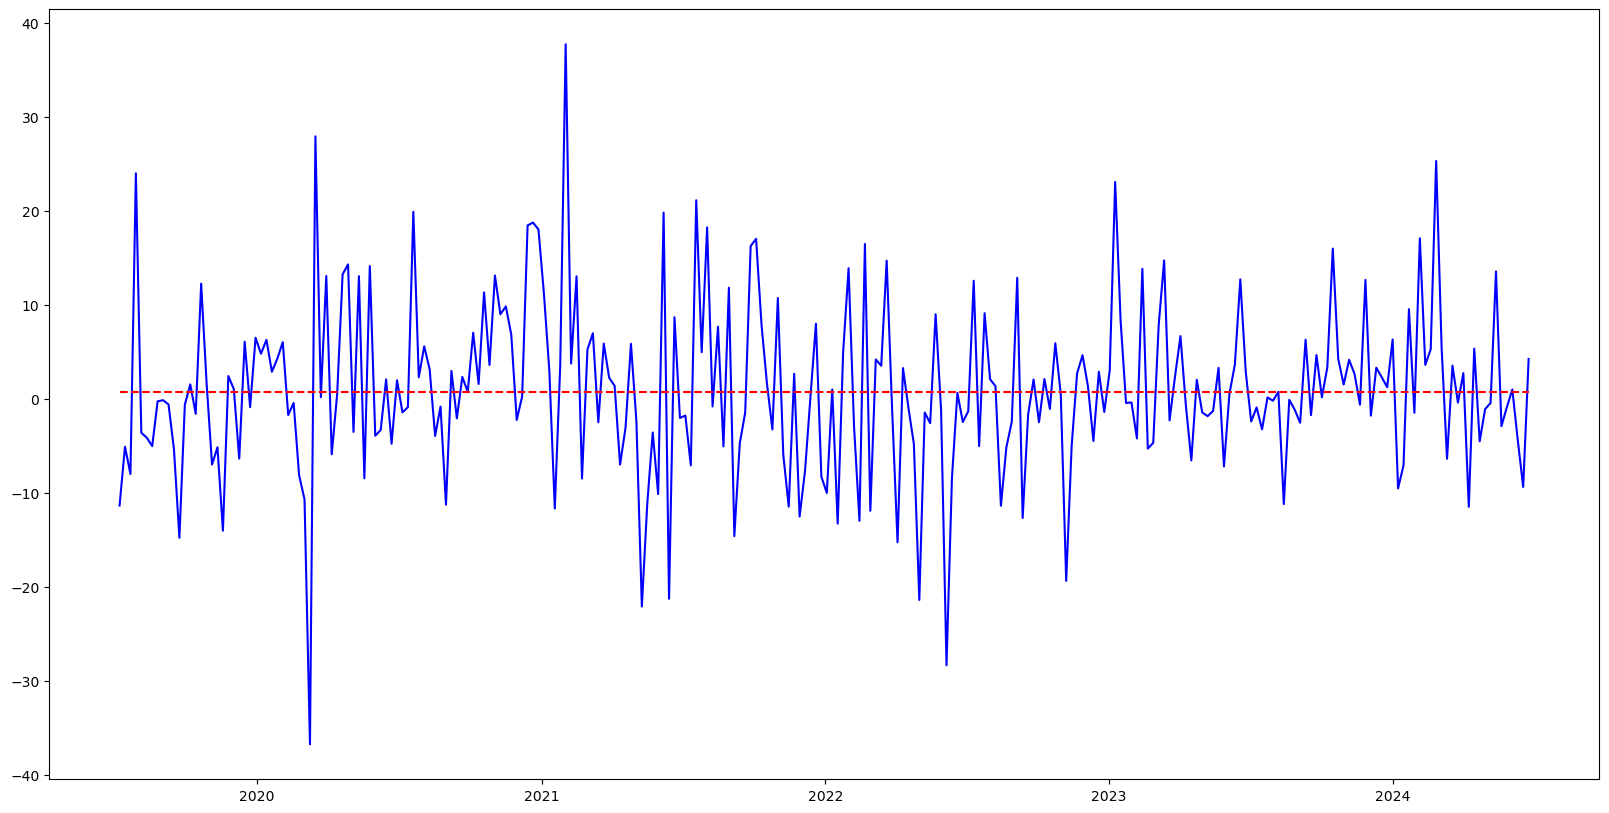

In [51]:
in_sample = returns[BTC] - garch11_fit.resid 

fig, ax1 = plt.subplots(1, 1, figsize=(20, 10))
ax1.plot(returns['Date'], returns[BTC], label='BTC Actuals', c='b')
ax1.plot(returns['Date'], in_sample, label='BTC Predict', c='r', linestyle="--")
fig.show()